In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

In [2]:

# Đọc dữ liệu
df = pd.read_csv('Heating Oil.csv').dropna()

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)


In [3]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,2.001,2.0293,2.0479,1.9791,55010,-1.11
1,2019-03-02 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
2,2019-03-03 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
3,2019-03-04 00:00:00,2.0143,1.9999,2.0377,1.9984,56050,0.66
4,2019-03-05 00:00:00,2.0164,2.011,2.0229,1.9909,45160,0.1
...,...,...,...,...,...,...,...
1914,2024-05-27 00:00:00,2.4393,2.41615,2.4551,2.4014,25415.0,0.32
1915,2024-05-28 00:00:00,2.465,2.4148,2.48,2.4131,28960,0.57
1916,2024-05-29 00:00:00,2.437,2.4801,2.4935,2.4295,22870,-1.14
1917,2024-05-30 00:00:00,2.3694,2.4305,2.4368,2.3637,18120,-2.77


In [4]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df.dropna()
df = df.reset_index(drop=True)

price = df['Price'].values
price = price.reshape(-1, 1)

In [5]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Heating Oil


## 7:3

In [6]:
train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled) * 0.3)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [7]:
# Hàm tạo tập dữ liệu với look_back
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)


In [8]:
look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Định hình lại dữ liệu để phù hợp với mô hình
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

In [9]:
# Huấn luyện mô hình
model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    max_features='sqrt', 
    random_state=42
)
model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', random_state=42)

In [10]:
# Dự báo 
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

In [11]:
# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))
test_score_mape = mean_absolute_percentage_error(Y_test, test_predict) * 100
test_score_mae = mean_absolute_error(Y_test, test_predict)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 0.2016453509952146
MAPE trên tập test là: 5.511060985212068 %
MAE trên tập test là: 0.15683166769803303


In [12]:

# Dự báo giá trị 90 ngày trong tương lai
last_20_days = price_scaled[-look_back:]
next_90_days = []

for i in range(90):
    x = last_20_days[-look_back:].reshape(1, look_back)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_20_days = np.append(last_20_days, y_hat.reshape(-1,1), axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print("Dự báo giá trị 90 ngày trong tương lai:")
print(next_90_days)

Dự báo giá trị 90 ngày trong tương lai:
[[2.4061695 ]
 [2.41476673]
 [2.43888937]
 [2.44022457]
 [2.43798489]
 [2.43842692]
 [2.45707635]
 [2.47161962]
 [2.47540838]
 [2.49474315]
 [2.5071517 ]
 [2.50130115]
 [2.5136451 ]
 [2.52473283]
 [2.55245336]
 [2.56442294]
 [2.5640071 ]
 [2.56370259]
 [2.56805114]
 [2.56953012]
 [2.5676125 ]
 [2.56667206]
 [2.56051775]
 [2.56263578]
 [2.56315154]
 [2.5577912 ]
 [2.53445348]
 [2.52679008]
 [2.51876419]
 [2.50713838]
 [2.50036134]
 [2.49729317]
 [2.49918707]
 [2.49070702]
 [2.46589791]
 [2.46155348]
 [2.46214423]
 [2.46064973]
 [2.45706638]
 [2.4559756 ]
 [2.45448368]
 [2.44871292]
 [2.44276801]
 [2.43045705]
 [2.42195358]
 [2.41996588]
 [2.41888117]
 [2.41482981]
 [2.41101028]
 [2.4189963 ]
 [2.42092852]
 [2.42391214]
 [2.42497534]
 [2.43276361]
 [2.43660844]
 [2.44389724]
 [2.45330901]
 [2.46519691]
 [2.47798378]
 [2.4866772 ]
 [2.49896932]
 [2.50686496]
 [2.51093115]
 [2.5270143 ]
 [2.55666365]
 [2.56316578]
 [2.56687062]
 [2.56399621]
 [2.5646

In [13]:

test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_90_days_df = pd.DataFrame(next_90_days)

next_90_index = range(len(df), len(df)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_90_days_df

,0
1919,2.406170
1920,2.414767
1921,2.438889
1922,2.440225
1923,2.437985
...,...
2004,2.461182
2005,2.461162
2006,2.460723
2007,2.460088


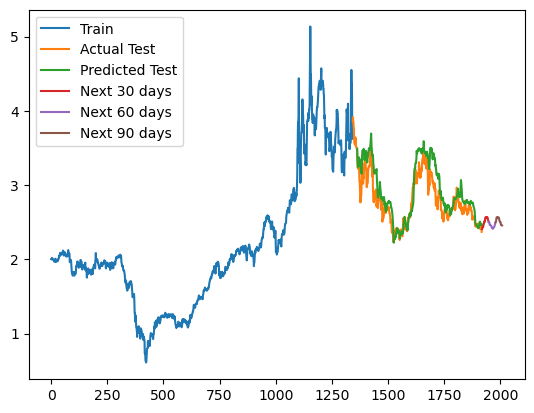

In [14]:

next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
plt.savefig("RF_Heating_Oil_Week6.png")

plt.legend()
plt.show()

## 8:2

In [15]:
train_size = int(len(price_scaled) * 0.8)
test_size = int(len(price_scaled) * 0.2)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [16]:

# Hàm tạo tập dữ liệu với look_back
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Định hình lại dữ liệu để phù hợp với mô hình
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

In [17]:
# Huấn luyện mô hình
model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    max_features='sqrt', 
    random_state=42
)
model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', random_state=42)

In [18]:
# Dự báo 
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

In [19]:
# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))
test_score_mape = mean_absolute_percentage_error(Y_test, test_predict) * 100
test_score_mae = mean_absolute_error(Y_test, test_predict)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 0.06712894065275554
MAPE trên tập test là: 1.7711696636578882 %
MAE trên tập test là: 0.04985796511945727


In [20]:
# Dự báo giá trị 90 ngày trong tương lai
last_20_days = price_scaled[-look_back:]
next_90_days = []

for i in range(90):
    x = last_20_days[-look_back:].reshape(1, look_back)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_20_days = np.append(last_20_days, y_hat.reshape(-1,1), axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print("Dự báo giá trị 90 ngày trong tương lai:")
print(next_90_days)


Dự báo giá trị 90 ngày trong tương lai:
[[2.39392003]
 [2.38683537]
 [2.37628504]
 [2.35982912]
 [2.33190911]
 [2.32408858]
 [2.32371626]
 [2.32987161]
 [2.3285841 ]
 [2.33689076]
 [2.35229991]
 [2.34974611]
 [2.34085806]
 [2.34510167]
 [2.33843096]
 [2.33821958]
 [2.33886043]
 [2.34830467]
 [2.35814302]
 [2.36138895]
 [2.36569561]
 [2.3648832 ]
 [2.36722009]
 [2.3645909 ]
 [2.36314895]
 [2.36463065]
 [2.36621075]
 [2.36511668]
 [2.36674388]
 [2.36759758]
 [2.36592116]
 [2.3649887 ]
 [2.36074544]
 [2.36163244]
 [2.36109325]
 [2.36053204]
 [2.36053204]
 [2.36053204]
 [2.35951959]
 [2.35838685]
 [2.35838685]
 [2.35838685]
 [2.35879863]
 [2.36096363]
 [2.35939213]
 [2.35939213]
 [2.35774185]
 [2.35714835]
 [2.35714835]
 [2.35756013]
 [2.35965343]
 [2.36211193]
 [2.36296218]
 [2.36105059]
 [2.35943829]
 [2.3610183 ]
 [2.36172166]
 [2.36296016]
 [2.36308561]
 [2.36156517]
 [2.36001915]
 [2.35925499]
 [2.3638104 ]
 [2.36308561]
 [2.3638422 ]
 [2.3622273 ]
 [2.35856154]
 [2.35840474]
 [2.3597

In [21]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_90_days_df = pd.DataFrame(next_90_days)

next_90_index = range(len(df), len(df)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_90_days_df

,0
1919,2.393920
1920,2.386835
1921,2.376285
1922,2.359829
1923,2.331909
...,...
2004,2.358469
2005,2.360809
2006,2.358720
2007,2.360496


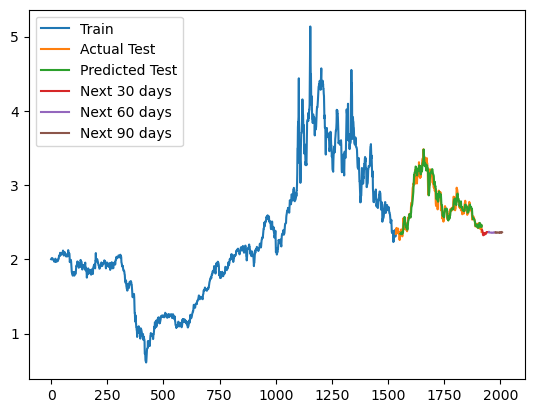

In [22]:
next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
plt.legend()
plt.show()

### 9:1

In [23]:
train_size = int(len(price_scaled) * 0.9)
test_size = int(len(price_scaled) * 0.1)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [24]:
# Hàm tạo tập dữ liệu với look_back
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Định hình lại dữ liệu để phù hợp với mô hình
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

In [25]:
# Huấn luyện mô hình
model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    max_features='sqrt', 
    random_state=42
)
model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', random_state=42)

In [26]:
# Dự báo 
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

In [27]:
# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))
test_score_mape = mean_absolute_percentage_error(Y_test, test_predict) * 100
test_score_mae = mean_absolute_error(Y_test, test_predict)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 0.04793539416745455
MAPE trên tập test là: 1.3326849412636332 %
MAE trên tập test là: 0.035516476698419154


In [28]:
# Dự báo giá trị 90 ngày trong tương lai
last_20_days = price_scaled[-look_back:]
next_90_days = []

for i in range(90):
    x = last_20_days[-look_back:].reshape(1, look_back)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_20_days = np.append(last_20_days, y_hat.reshape(-1,1), axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print("Dự báo giá trị 90 ngày trong tương lai:")
print(next_90_days)


Dự báo giá trị 90 ngày trong tương lai:
[[2.39460514]
 [2.39156182]
 [2.3892126 ]
 [2.36150512]
 [2.34051545]
 [2.33516105]
 [2.33129133]
 [2.33418684]
 [2.34682682]
 [2.3435726 ]
 [2.36018517]
 [2.36321538]
 [2.35885843]
 [2.35484587]
 [2.35379783]
 [2.35482527]
 [2.35033591]
 [2.36287788]
 [2.37144292]
 [2.37120943]
 [2.36932068]
 [2.36792422]
 [2.36151875]
 [2.36284084]
 [2.35953117]
 [2.36469569]
 [2.36992514]
 [2.37324603]
 [2.37548544]
 [2.37305656]
 [2.36536787]
 [2.36289826]
 [2.36040373]
 [2.35778147]
 [2.36307063]
 [2.36793659]
 [2.37175488]
 [2.37614686]
 [2.37437384]
 [2.36511423]
 [2.35922122]
 [2.35542471]
 [2.35738829]
 [2.3628762 ]
 [2.36977613]
 [2.3731705 ]
 [2.37601526]
 [2.37452676]
 [2.36427444]
 [2.35824573]
 [2.35647326]
 [2.35822455]
 [2.36481878]
 [2.37159672]
 [2.37469846]
 [2.37549772]
 [2.37486333]
 [2.36377043]
 [2.35774462]
 [2.35476284]
 [2.3580305 ]
 [2.36539515]
 [2.37021519]
 [2.37611996]
 [2.37563456]
 [2.37486333]
 [2.36324547]
 [2.35866015]
 [2.3554

In [29]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_90_days_df = pd.DataFrame(next_90_days)

next_90_index = range(len(df), len(df)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_90_days_df

,0
1919,2.394605
1920,2.391562
1921,2.389213
1922,2.361505
1923,2.340515
...,...
2004,2.358545
2005,2.355301
2006,2.357954
2007,2.366175


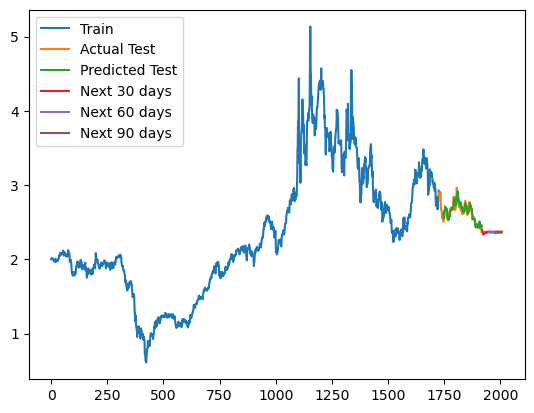

In [30]:
next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
plt.legend()
plt.show()